In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import datetime
import arviz
import seaborn as sns
import scipy
import sklearn.metrics
import pickle

sns.set()

In [2]:
dates_to_test = ['2020-10-05', '2020-10-12', '2020-10-19',
       '2020-10-26', '2020-11-02', '2020-11-10', '2020-11-16',
       '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
       '2020-12-21']

## Load and prepare the data

In [3]:
# data_new = pd.read_csv('data/df_SIVEP_nowcast_allStates_08-02-2021.csv')
data_new = pd.read_csv('data/df_SIVEP_nowcast_Brazil_31-05-2021.csv')

# def get_state_data(df, state):
#     df_state = df.copy()
#     if state == 'Brazil':
#         df_state.drop(columns=['State'], inplace=True)
#         columns = list(df_state.columns)
#         columns.remove('Deaths')
#         df_state = df_state.groupby(columns, as_index=False)['Deaths'].sum()
#         return df_state
#     return df_state[df_state['State'] == state]

# data_new = get_state_data(data_new, 'Brazil')

print("First date:", data_new.Date.values[0])
print("Last date:", data_new.Date.values[-1])

data = data_new.copy()
data['Release_index'] = data.Release.astype('category').cat.codes
# Filter the data

first_date = '2020-06-30'  # best not to include the first releases
data = data[data['Date'] >= first_date] # cut off early days as they are less relevant
data = data[data['Release'] >= first_date] # cut off early days as they are less relevant

max_D = 10 # maximum delay in the model
data.head()

First date: 2019-12-31
Last date: 2021-05-30


,Date,Deaths,Release,Date_index,Release_index
180,2020-06-30,659,2020-07-07,181,0
181,2020-07-01,622,2020-07-07,182,0
182,2020-07-02,586,2020-07-07,183,0
183,2020-07-03,446,2020-07-07,184,0
184,2020-07-04,419,2020-07-07,185,0


In [4]:
data.Release.unique()

array(['2020-07-07', '2020-07-14', '2020-07-21', '2020-07-29',
       '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24',
       '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21',
       '2020-09-28', '2020-10-05', '2020-10-12', '2020-10-19',
       '2020-10-26', '2020-11-02', '2020-11-10', '2020-11-16',
       '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
       '2020-12-21', '2020-12-28', '2021-01-04', '2021-01-11',
       '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08',
       '2021-02-15', '2021-02-22', '2021-03-01', '2021-03-08',
       '2021-03-15', '2021-03-22', '2021-03-29', '2021-04-05',
       '2021-04-12', '2021-04-19', '2021-04-26', '2021-05-03',
       '2021-05-10', '2021-05-17', '2021-05-24', '2021-05-31'],
      dtype=object)

In [5]:
# Utility functions for preparing the data

def sum_two_values(val1, val2):
    """Sums two values, treats NaN as 0 if one value is NaN, returns NaN if both values are NaN.
    Used for summing vectors of deaths."""
    if np.isnan(val1) & np.isnan(val2):
        return np.nan
    if np.isnan(val2):
        return val1
    return val1 + val2

def sum_two_vectors(vec1, vec2):
    """Used for getting a total number of deaths per day reported."""
    vec1 = vec1.values
    vec2 = vec2.values
    # if both values are NaN, sum should give NaN
    # if only one is NaN, this NaN should be treated as 0
    for i in range(len(vec1)):
        vec1[i] = sum_two_values(vec1[i], vec2[i])
    return vec1


def get_weeks_vector(n):
    week_vec = []
    week=0
    counter=0
    for i in range(n):
        week_vec.append(week)
        counter += 1
        if counter == 7:
            counter=0
            week = week+1
    return week_vec

def create_reporting_triangle(raw_data):
    """Creates a reporting triangle from SIVEP data binned by date and release"""
    # create and empty Dataframe to store the reporting triangle
    index = raw_data.Date.unique()  # all Dates in the dataset
    columns = np.sort(raw_data.Release_index.unique()) # maximum number of weeks (releases)
    triangle = pd.DataFrame(index = index, columns = columns)
    
    # fill in the delays info
    for i in triangle.index:  # iterate over all dates
        current_date = raw_data[raw_data['Date'] == i]  # get reported deaths for this date for every release
        all_deaths = current_date.Deaths.values
        # take the first number of deaths appearing -- this is 0 delay
        triangle.loc[i,0] = all_deaths[0]
        next_releases = current_date.Release_index.values
        first_release = next_releases[0]
        for j in range(1,len(all_deaths)):
            triangle.loc[i,next_releases[j]-first_release] = all_deaths[j] - all_deaths[j-1]
    return triangle

def sum_up_delays_above_max(triangle, max_D = max_D):
    """Sums up all deaths reported with delay larger than max_delay in the reporting triangle"""
    triangle_max_D = triangle.copy()
    max_delays_reported = int(triangle_max_D.columns[-1])
    for c in range(max_D+1, max_delays_reported+1):
        triangle_max_D.loc[:,max_D] = sum_two_vectors(triangle_max_D.loc[:,max_D],
                                                        triangle_max_D.loc[:,c])
        triangle_max_D.drop(columns = [c], inplace = True)
    return triangle_max_D

def mask_bottom_triangle(unmasked_triangle, val=0):
    """Adds a mask to obtain a correct reporting triangle;
    issue arising due to the fact that releases are not in equal weekly intervals"""
    nrow = unmasked_triangle.shape[0]
    ncol = unmasked_triangle.shape[1]
    masked_triangle = unmasked_triangle.copy()
    
    for c in range(0, ncol-1):
        masked_triangle.iloc[nrow-c-1,c+1] = val
    return masked_triangle

def test_reporting_triangle(triangle):
    """Tests whether the reporting triangle has a correct structure.
    Returns True if the structure is correct and False if it is not."""
    test_triangle = triangle.copy()  
    test_triangle.replace(0, np.nan, inplace=True) # might cause issues if 0s are outside of the missing information
    nans_per_row = test_triangle.isnull().sum(axis=1)

    for i in range(1,len(nans_per_row.values)):
        if nans_per_row[i] - nans_per_row[i-1] > 1:
            return False
        if nans_per_row[i] > 0:
            if nans_per_row[i] - nans_per_row[i-1] != 1:
                return False
    return True    

def mask_below_diagonal(triangle):
    """Makes all values below nan value to be nan"""
    nrow = triangle.shape[0]
    ncol = triangle.shape[1]
    masked_triangle = triangle.copy()
    
    for c in range(1, ncol):
        nan_idx = np.argwhere(np.isnan(masked_triangle.iloc[:,c].values))
        if nan_idx:
            for r in range(nan_idx[0][0], nrow):
                masked_triangle.iloc[r,c] = np.nan
    return masked_triangle

def get_results_df(fit, savefile = ''):
    fit_df_GP = fit.extract()['sum_n_predict']
    
    predicted_GP_mean = np.mean(fit_df_GP, axis = 0)
    predicted_GP_median = np.median(fit_df_GP,axis = 0)
    predicted_q025_GP = np.quantile(fit_df_GP,0.025,axis=0)
    predicted_q975_GP = np.quantile(fit_df_GP,0.975,axis=0)
    predicted_q25_GP = np.quantile(fit_df_GP,0.25,axis=0)
    predicted_q75_GP = np.quantile(fit_df_GP,0.75,axis=0)
    
    nowcasted_data = pd.DataFrame(columns = ['week','mean', 'median', 'q025', 'q975', 'q25', 'q75'])
    nowcasted_data['week'] = range(len(predicted_GP_mean))
    nowcasted_data['mean'] = predicted_GP_mean.astype(int)
    nowcasted_data['median'] = predicted_GP_median.astype(int)
    nowcasted_data['q025'] = predicted_q025_GP.flatten().astype(int)
    nowcasted_data['q975'] = predicted_q975_GP.flatten().astype(int)
    nowcasted_data['q25'] = predicted_q25_GP.flatten().astype(int)
    nowcasted_data['q75'] = predicted_q75_GP.flatten().astype(int)

    if savefile:
        nowcasted_data.to_csv(savefile + '.csv', index=False)
    return nowcasted_data

def nowcasting_error(deaths_nowcasted, deaths_true, weeks_test, method):
    """method: 'MSE', 'MAE', 'RMSE'
    weeks_test: how many last weeks use for testing"""
    n = len(deaths_nowcasted)
    deaths_true = deaths_true[:n] # doesn't matter what is later
    deaths_true = deaths_true[-weeks_test:] # we only test last few weeks
    deaths_nowcasted = deaths_nowcasted[-weeks_test:]
    
    if method == 'MSE':
        return sklearn.metrics.mean_squared_error(y_true = deaths_true, y_pred = deaths_nowcasted, squared = True)
    elif method == 'RMSE':
        return sklearn.metrics.mean_squared_error(y_true = deaths_true, y_pred = deaths_nowcasted, squared = False)
    elif method == 'MAE':
        return sklearn.metrics.mean_absolute_error(y_true = deaths_true, y_pred = deaths_nowcasted)
    else:
        print('Wrong method')
        return -1000

    
def nowcasting_error_weighted(deaths_nowcasted, deaths_true, deaths_raw,
                              weeks_test, method):
    """method: 'MSE', 'MAE', 'RMSE'
    weeks_test: how many last weeks use for testing"""
    n = len(deaths_nowcasted)
    deaths_true = deaths_true[:n] # doesn't matter what is later
    deaths_true = deaths_true[-weeks_test:] # we only test last few weeks
    deaths_nowcasted = deaths_nowcasted[-weeks_test:]
    deaths_raw = deaths_raw[-weeks_test:]
    
    # calculate the weights
    weights = abs(deaths_true - deaths_raw)

    if method == 'MSE':
        return sklearn.metrics.mean_squared_error(y_true = deaths_true, 
                                                  y_pred = deaths_nowcasted, 
                                                  sample_weight = weights,
                                                  squared = True)
    elif method == 'RMSE':
        return sklearn.metrics.mean_squared_error(y_true = deaths_true, 
                                                  y_pred = deaths_nowcasted,
                                                  sample_weight = weights,
                                                  squared = False)
    elif method == 'MAE':
        return sklearn.metrics.mean_absolute_error(y_true = deaths_true,
                                                   y_pred = deaths_nowcasted,
                                                   sample_weight = weights)

    else:
        print('Wrong method')
        return -1000

In [6]:
# Prepare the data for validation -- only the most recent release, binned by weeks
data_validation_daily = data[data['Release_index'] == data['Release_index'].values[-1]].copy()
data_validation_daily.index = data_validation_daily['Date'].values
data_validation_daily.drop(columns = ['Date', 'Release', 'Date_index', 'Release_index'], inplace = True)
data_validation_daily.rename(columns={"Deaths": "all_deaths"}, inplace = True)

# bin the data into weeks
first_date = datetime.datetime.strptime(data_validation_daily.index[0],'%Y-%m-%d')
last_date = datetime.datetime.strptime(data_validation_daily.index[-1],'%Y-%m-%d')
data_validation_daily['week'] = get_weeks_vector(len(data_validation_daily.index))


data_validation_weekly = data_validation_daily.groupby(['week']).sum(min_count=1)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [7]:
def nowcasting_prep(now_date, maxD=max_D):

    # Prepare the data for nowcasting
    data_filtered = data[data['Release'] <= now_date].copy() # remove the data above nowcasting date

    # 1. Change the Release index to start from 0
    releases = np.sort(data_filtered.Release_index.unique())
    for i in range(len(releases)):
        data_filtered.loc[data_filtered["Release_index"] == releases[i], "Release_index"] = i

    # 2. Create a reporting triangle for the validation data
    delays_data = create_reporting_triangle(data_filtered)

    # 3. Sum up the deaths above max_D (maximum delay to be used)
    delays_data = sum_up_delays_above_max(delays_data, maxD)

    # 4. Bin the data into weeks
    first_date = datetime.datetime.strptime(delays_data.index[0],'%Y-%m-%d')
    last_date = datetime.datetime.strptime(delays_data.index[-1],'%Y-%m-%d')
    delays_data['week'] = get_weeks_vector(len(delays_data.index))

#     all_weeks = int((last_date - first_date).days / 7)  #+1?

#     for i in delays_data.index:
#         delays_data.loc[i,'week'] = get_weeks(i, last_date, all_weeks)

    delays_data_weekly = delays_data.groupby(['week']).sum(min_count=1)

    # 5. Mask some values
    # this is done to keep a correct structure of the reporting triangle
    # this issue is cause because the columns are 'releases' and rows are 'weeks', and the release tend to be weekly
    # with some shorter/longer periods in the beginning of August
    delays_data_weekly = mask_bottom_triangle(delays_data_weekly)

    # 5.5 change the begative values into 0s
    delays_data_weekly[delays_data_weekly < 0] = 0


    # 6. Add a total number of deaths per date reported
    delays_data_weekly["all_deaths"] = delays_data_weekly.sum(axis=1)
    
    triangle = delays_data_weekly.iloc[:,:-1].copy()
    triangle = mask_bottom_triangle(triangle, np.nan)
    triangle = mask_below_diagonal(triangle)
    triangle.replace(np.nan, 10000000, inplace=True)
    triangle = triangle.astype('int32')

    return delays_data_weekly, triangle

In [8]:
# delays_data_weekly_validation, _   = nowcasting_prep('2021-02-09')
delays_data_weekly_validation, _   = nowcasting_prep('2021-06-01')

delays_data_weekly_validation

,0,1,2,3,4,5,6,7,8,9,10,all_deaths
week,,,,,,,,,,,,
0,3386,2320,847,572,146,269,166,220,158,92,783,8959
1,3376,2542,958,299,349,234,233,213,98,74,840,9216
2,3649,2493,572,609,351,247,260,126,75,86,783,9251
3,4308,1483,979,517,362,279,164,106,67,90,692,9047
4,2100,3209,1165,545,311,212,127,124,100,93,604,8590
5,3021,2596,786,446,208,159,153,105,92,74,643,8283
6,2752,2559,774,357,230,176,129,148,58,62,612,7857
7,2704,2314,595,320,213,171,143,91,64,71,594,7280
8,2631,2208,632,381,209,147,132,66,94,69,615,7184


In [9]:
delays_data = dict()
triangles = dict()
for d in dates_to_test:
    delays, tri = nowcasting_prep(d)
    delays_data.update({d: delays})
    triangles.update({d: tri})

### Load previously saved results of the retrospective tests

In [10]:
def read_results(loadfile):
    dic = {}
    for d in dates_to_test:
        load = pd.read_csv(loadfile + '_' + d + '.csv')
        dic.update({d: load})
    return dic


results_SE_4comp = read_results('tests_results/SE_4comp')
results_SE_2comp = read_results('tests_results/SE_2comp')
results_nobbs = read_results('tests_results/nobbs')
results_SE_1comp = read_results('tests_results/SE_1comp')
results_matern2comp32 = read_results('tests_results/matern2comp32')
results_matern4comp32 = read_results('tests_results/matern4comp32')
results_matern2comp12 = read_results('tests_results/matern2comp12')
results_matern4comp12 = read_results('tests_results/matern4comp12')
results_kron = read_results('tests_results/kron')
results_kron_additive = read_results('tests_results/kron_2D_additive')

## Evaluate the errors: RMSE, MAE, MSE, weighted RMSE

In [11]:
MAE_df = pd.DataFrame(index = dates_to_test)
MSE_df = pd.DataFrame(index = dates_to_test)
RMSE_df = pd.DataFrame(index = dates_to_test)
RMSE_df_weighted = pd.DataFrame(index = dates_to_test)

reported = data_validation_weekly.all_deaths.values

models_names = ['SE_4comp', 'SE_2comp', 'nobbs', 
                'SE_1comp', 'kron', 'matern_2comp32', 'matern_4comp32',
               'matern_2comp12', 'matern_4comp12','kron_additive']

models_results = [results_SE_4comp, results_SE_2comp, results_nobbs, 
                  results_SE_1comp, results_kron, results_matern2comp32, results_matern4comp32,
                 results_matern2comp12, results_matern4comp12, results_kron_additive]

for i in range(len(models_names)):
    mae = []
    mse = []
    rmse = []
    rmse_weight = []
    for d in dates_to_test:
        try:
            nowcasted = models_results[i][d]['mean'].values

            raw = delays_data[d].all_deaths.values
#             w = len(nowcasted)
            w = 10
            mae.append(int(nowcasting_error(nowcasted, reported, weeks_test=w, method='MAE')))
            mse.append(int(nowcasting_error(nowcasted, reported, weeks_test=w, method='MSE')))
            rmse.append(int(nowcasting_error(nowcasted, reported, weeks_test=w, method='RMSE')))
            rmse_weight.append(int(nowcasting_error_weighted(nowcasted, reported, raw,
                                                             weeks_test=w, method='RMSE')))

        except:
            print(models_names[i], d)
            mae.append(np.nan)
            mse.append(np.nan)
            rmse.append(np.nan)
            rmse_weight.append(np.nan)

    MAE_df[models_names[i]] = mae
    MSE_df[models_names[i]] = mse
    RMSE_df[models_names[i]] = rmse
    RMSE_df_weighted[models_names[i]] = rmse_weight


In [12]:
RMSE_df

,SE_4comp,SE_2comp,nobbs,SE_1comp,kron,matern_2comp32,matern_4comp32,matern_2comp12,matern_4comp12,kron_additive
2020-10-05,436,563,466,647,430,489,412,485,431,380
2020-10-12,406,552,537,720,557,490,438,470,487,365
2020-10-19,428,839,530,622,496,731,383,694,416,369
2020-10-26,348,798,478,531,351,758,362,846,414,212
2020-11-02,400,878,503,579,482,788,458,386,527,337
2020-11-10,525,806,718,729,612,570,598,629,673,558
2020-11-16,365,956,463,504,236,648,436,378,528,252
2020-11-23,513,859,450,630,487,243,603,559,709,449
2020-11-30,478,1000,364,643,190,289,606,625,290,173
2020-12-07,779,764,467,833,664,743,848,828,606,33888


In [15]:
def plot_error_per_date(df, title, ls='-', show_mean = True, show_legend=True):
    x = df.columns
    color_dict = {'nobbs': 'tab:blue', 'SE_4comp': 'tab:green', 'kron': 'tab:orange',
                  'NobBS': 'tab:blue', 'matern_4comp12': 'tab:green',
                 'kron_additive': 'tab:red'}
    label_dict = {'nobbs': 'NobBS', 'SE_4comp': '1D split SE+SE', 'kron': '2D mixture',
                  'NobBS': 'NobBS', 'matern_4comp12': '2x(SE+Mat(1/2) GP model',
                 'kron_additive': '2D additive'}

    for r in range(len(df.index)):

#         if df.index[r] in ['NobBS', 'nobbs', 'kron', 'SE_4comp', 'kron_additive']:
        if df.index[r] in ['NobBS', 'nobbs', 'SE_4comp', 'kron_additive']:

            plt.plot(x, df.iloc[r,:].values, label=label_dict[df.index[r]],
                     color= color_dict[df.index[r]], ls=ls)
            if show_mean:
                plt.axhline(df.iloc[r,:].mean(), ls='--', color= color_dict[df.index[r]])

    xticks = list(x[::2]) # take every other date
    xlabs = [datetime.datetime.strptime(d,'%Y-%m-%d').strftime("%b-%d") for d in xticks]
    plt.xticks(xticks, labels=xlabs, rotation=45,fontsize=12)
    plt.yticks(range(200,810,200), fontsize=12)
    plt.ylim([200, 800])
    plt.ylabel(title,fontsize=16)
    if show_legend:
        plt.legend(fontsize='medium', loc='upper right')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

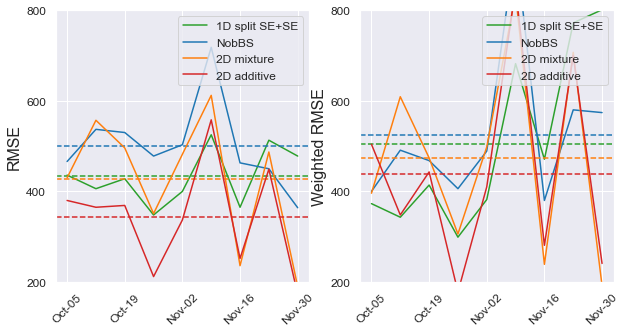

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_error_per_date(RMSE_df.iloc[0:-3,:].T, 'RMSE')
plt.subplot(1,2,2)
plot_error_per_date(RMSE_df_weighted.iloc[0:-3,:].T, 'Weighted RMSE')
plt.show()

### Figure 4B

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

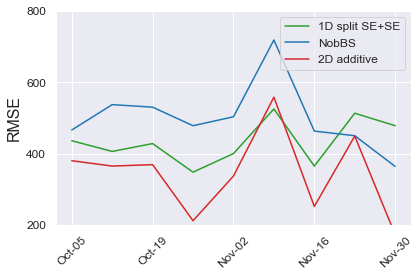

In [16]:
plot_error_per_date(RMSE_df.iloc[0:-3,:].T, 'RMSE', '-', show_mean=False, show_legend=True)
# plot_error_per_date(RMSE_df_weighted.iloc[0:-3,:].T, 'RMSE', '--', show_mean=False, show_legend=False)

plt.tight_layout()
plt.show()
# plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/rmse_unweighted_lines.pdf', bbox_inches='tight')

### Violinplots for Figure 4A

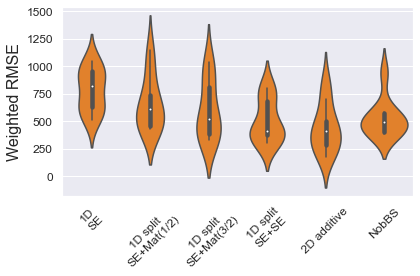

In [17]:
df_for_boxplot = RMSE_df_weighted.iloc[0:-3,:].copy()

df_for_boxplot.rename(columns={"SE_4comp": "1D split\nSE+SE", "SE_2comp": " 1D\nSE+SE",
                               "nobbs": "NobBS", "SE_1comp": "1D\nSE", 
                               "matern_2comp32": "1D SE+Mat(3/2)", 
                               "matern_4comp32": "1D split\nSE+Mat(3/2)",
                               "matern_2comp12": "1D SE+Mat(1/2)", 
                               "matern_4comp12": "1D split\nSE+Mat(1/2)",
                              "kron": "2D mixture",
                              "kron_additive": "2D additive"},
                                inplace=True)



# order = ['1D\nSE', '1D split\nSE+Mat(1/2)', '1D split\nSE+Mat(3/2)',
#          '1D split\nSE+SE',  '2D mixture', '2D additive', 'NobBS']
order = ['1D\nSE', '1D split\nSE+Mat(1/2)', '1D split\nSE+Mat(3/2)',
         '1D split\nSE+SE', '2D additive', 'NobBS']

df_for_boxplot.drop(columns=[col for col in df_for_boxplot if col not in order], inplace=True)

melt = pd.melt(df_for_boxplot)

melt.variable = pd.Categorical(melt.variable, categories=order)
melt.sort_values(by='variable', inplace=True)

# boxplot
# sns.boxplot(x="variable", y="value", data=melt, color='tab:orange',
#             showmeans=True, meanprops={"marker":"o",
#                        "markerfacecolor":"red", 
#                        "markeredgecolor":"red",
#                       "markersize":"5"},
#             orient="v", boxprops=dict(alpha=.3))

# points
# sns.swarmplot(x="variable", y="value", data=melt, color='tab:orange',
#             orient="v")

# violinplot
sns.violinplot(x="variable", y="value", data=melt, color='tab:orange',
            showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"red",
                      "markersize":"5"},
            orient="v", alpha=0.3)

plt.xticks(fontsize=12, rotation = 45)
plt.yticks(fontsize=12)

plt.xlabel('')
plt.ylabel('Weighted RMSE', fontsize=16)
plt.tight_layout()
plt.show()

melt_weighted = melt

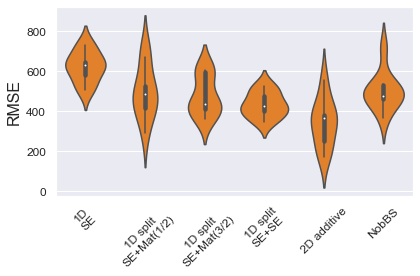

In [18]:
df_for_boxplot = RMSE_df.iloc[0:-3,:].copy()

df_for_boxplot.rename(columns={"SE_4comp": "1D split\nSE+SE", "SE_2comp": " 1D\nSE+SE",
                               "nobbs": "NobBS", "SE_1comp": "1D\nSE", 
                               "matern_2comp32": "1D SE+Mat(3/2)", 
                               "matern_4comp32": "1D split\nSE+Mat(3/2)",
                               "matern_2comp12": "1D SE+Mat(1/2)", 
                               "matern_4comp12": "1D split\nSE+Mat(1/2)",
                              "kron": "2D mixture",
                              "kron_additive": "2D additive"},
                                inplace=True)



# order = ['1D\nSE', '1D split\nSE+Mat(1/2)', '1D split\nSE+Mat(3/2)',
#          '1D split\nSE+SE',  '2D mixture', '2D additive', 'NobBS']
order = ['1D\nSE', '1D split\nSE+Mat(1/2)', '1D split\nSE+Mat(3/2)',
         '1D split\nSE+SE', '2D additive', 'NobBS']


df_for_boxplot.drop(columns=[col for col in df_for_boxplot if col not in order], inplace=True)

melt = pd.melt(df_for_boxplot)

melt.variable = pd.Categorical(melt.variable, categories=order)
melt.sort_values(by='variable', inplace=True)

# sns.boxplot(x="variable", y="value", data=melt, color='tab:orange',
#             showmeans=True, meanprops={"marker":"o",
#                        "markerfacecolor":"red", 
#                        "markeredgecolor":"red",
#                       "markersize":"5"},
#             orient="v", boxprops=dict(alpha=.3))
# violinplot
sns.violinplot(x="variable", y="value", data=melt, color='tab:orange',
            showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"red",
                      "markersize":"5"},
            orient="v", alpha=0.3)
plt.xticks(fontsize=12, rotation = 45)
plt.yticks(fontsize=12)

plt.xlabel('')
plt.ylabel('RMSE', fontsize=16)
plt.tight_layout()
plt.show()

melt_unweighted = melt

In [19]:
melt_weighted['Weighted'] = 'Weighted'
melt_unweighted['Weighted'] = 'Unweighted'
melt_both = pd.concat([melt_weighted, melt_unweighted])

In [21]:
pd.unique(melt_both.variable)

['1D\nSE', '1D split\nSE+Mat(1/2)', '1D split\nSE+Mat(3/2)', '1D split\nSE+SE', '2D additive', 'NobBS']
Categories (6, object): ['1D\nSE', '1D split\nSE+Mat(1/2)', '1D split\nSE+Mat(3/2)', '1D split\nSE+SE', '2D additive', 'NobBS']

In [22]:
drop_models = ['1D split\nSE+Mat(1/2)', '1D split\nSE+Mat(3/2)', '1D split\nSE+Mat(1/2)', '1D split\nSE+Mat(3/2)']

In [23]:
melt_both.variable = melt_both.variable.astype(str)

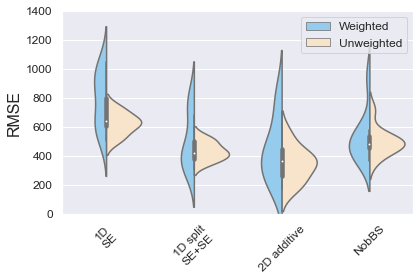

In [25]:
sns.violinplot(x="variable", y="value", data=melt_both[~melt_both.variable.isin(drop_models)], hue='Weighted', split=True, 
               showmeans=True,orient="v", inner='box', palette=["lightskyblue", "bisque"])
# sns.stripplot(x="variable", y="value", data=melt_both, jitter=True)
plt.xticks(fontsize=12, rotation = 45)
plt.yticks(fontsize=12)

plt.xlabel('')
plt.ylabel('RMSE', fontsize=16)

plt.legend(title='', fontsize='medium')
plt.tight_layout()
plt.ylim(0,1400)
plt.show()

# plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/rmse_violin.pdf', bbox_inches='tight')

### Plots for Figures 5 and S18-S26 (retrospective fits vs raw data and ground truth)

In [276]:
models_names = ['4-components 4xSE GP model', '2-components 2xSE GP model', 'NobBS Model', '1-components 1xSE GP model', 
                   '2D mixture GP model', '2-components SE+Mat(3/2) GP model', '4-components 2x(SE+Mat(3/2)) GP model', 
                   '2-components SE+Mat(1/2) GP model',
                  '4-components 2x(SE+Mat(1/2)) GP model', '2D additive GP model',]

models_results = [results_SE_4comp, results_SE_2comp, results_nobbs, results_SE_1comp, results_kron,
                  results_SE_1comp, results_matern2comp32, results_matern4comp32, results_matern2comp12,
                  results_matern4comp12]

reported = data_validation_weekly.all_deaths.values



def single_plot(date, crI = 50, mean = False, models = [0,1,2,3,4], legend=True):
    colors= ['orange', 'magenta', 'green', 'violet', 'cyan', 'yellow', 'black']
    colors = colors + colors
    used_for_nowcast = delays_data[date]
    x = used_for_nowcast.index + 27
    for i in models:        
        label = models_names[i]
#         c = colors[i]
        c = colors[0]

        if crI == 50:
            q25 = models_results[i][date]['q25'].values
            q75 = models_results[i][date]['q75'].values
            plt.fill_between(x, y1=q25,
                 y2=q75, alpha = 0.3, 
                 label = label, color = c)
        elif crI == 95:
            q025 = models_results[i][date]['q025'].values
            q975 = models_results[i][date]['q975'].values
            plt.fill_between(x, y1=q025,
                     y2=q975, alpha = 0.4, 
                     label = label, color = c)

#         if mean:
#             means = models_results[i][date]['mean'].values
#             plt.plot(x, means, 
#                 label = '_mean', ls='dotted', color='black', lw=4)
        if mean:
            means = models_results[i][date]['mean'].values
            if crI is not None:
                plt.plot(x, means, label = '_mean', ls='-', color='black', lw=2, alpha=0.7)
            else:
                plt.plot(x, means, label = '_mean', ls='-', color=c, lw=4)
        
    plt.scatter(np.asarray(range(len(reported[:-10])))+27, reported[:-10], 
                label = '_true', color='blue',s=3)
    plt.plot(x, used_for_nowcast.all_deaths.values, 
                label = '_used for nowcasting', ls='--', color='red')
    
    plt.ylim([1000,11000])
    plt.xlim([27,55])
    plt.text(37, 9500, date, bbox=dict(alpha=0.2))
#     plt.title(date)
    
    if legend:
        plt.legend()
    
def plot_all(crI=50, mean = False, models = [0,1,2,3,4], showdates=4, title=''):

# for showing 4 dates
    if showdates==4:
        fig = plt.figure(figsize=(6,4))
#         dates = dates_to_test[4::2]
        dates = dates_to_test[1:-3:2]
        for i in range(len(dates)):
            date = dates[i]
            fig.add_subplot(2,2,i+1)
            ln = False
            ld = False
            if (i+1) == 2:
                ln = True
            if (i+1) == 4:
                ld = True
            single_plot_with_legend(date, crI, mean, models, legend_nowcast=ln, legend_data=ld)
    #         if ((i+1) in [5,6,7,8]):
    #                 plt.xlabel('Epidemiological week')
    #         if ((i+1) in [1,5]):
    #                 plt.ylabel('Number of deaths per week')
            plt.yticks([3000,6000,9000],fontsize=12)
            plt.xticks(fontsize=12)

            if ((i+1) in [2,4]):
                    frame = plt.gca()
                    frame.axes.yaxis.set_ticklabels([])
            if ((i+1) in [1,2]):
                    frame = plt.gca()
                    frame.axes.xaxis.set_ticklabels([])
        fig.text(0.55, 0.00001, 'Epidemiological week', ha='center', fontsize=16)
        fig.text(0.00001, 0.5, 'Number of deaths per week', va='center', rotation='vertical', fontsize=16)

    # for showing 12 dates
    elif showdates==12:
        fig = plt.figure(figsize=(10,8))
        dates = dates_to_test[0:]
        for i in range(len(dates)):
            date = dates[i]
            fig.add_subplot(3,4,i+1)
            single_plot(date, crI, mean, models, legend=False)
            plt.yticks([3000,6000,9000],fontsize=12)
            plt.xticks(fontsize=12)

            if ((i+1) in [2,3,4,6,7,8,10,11,12,14,15,16]):
                    frame = plt.gca()
                    frame.axes.yaxis.set_ticklabels([])
            if ((i+1) in [13,14,15,16]):
                    frame = plt.gca()
                    frame.axes.xaxis.set_ticklabels([])
        fig.text(0.5, 0.00001, 'Epidemiological week', ha='center', fontsize=14)
        fig.text(0.00001, 0.5, 'Number of deaths per week', va='center', rotation='vertical', fontsize=14)
        
        # for showing 9 dates
    elif showdates==9:
        fig = plt.figure(figsize=(10,8))
        dates = dates_to_test[0:-3]
        for i in range(len(dates)):
            date = dates[i]
            fig.add_subplot(3,3,i+1)
            single_plot(date, crI, mean, models, legend=False)
            plt.yticks([3000,6000,9000],fontsize=12)
            plt.xticks(fontsize=12)

            if ((i+1) in [2,3,5,6,8,9]):
                    frame = plt.gca()
                    frame.axes.yaxis.set_ticklabels([])
            if ((i+1) in [1,2,3,4,5,6]):
                    frame = plt.gca()
                    frame.axes.xaxis.set_ticklabels([])
        fig.text(0.5, 0.00001, 'Epidemiological week', ha='center', fontsize=14)
        fig.text(0.00001, 0.5, 'Number of deaths per week', va='center', rotation='vertical', fontsize=14)
        
        
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    

In [294]:
# def single_plot_with_legend(date, crI = 50, mean = False, models = [0,1,2,3,4], legend=True):
def single_plot_with_legend(date, crI = 50, mean = False, models = [0,1,2,3,4], legend_nowcast=False, legend_data=False):
    colors= ['orange', 'magenta', 'green', 'violet', 'cyan', 'yellow', 'black']
    colors = colors + colors
    used_for_nowcast = delays_data[date]
    x = used_for_nowcast.index + 27
    
    label_cr95 = ''
    label_mean = ''
    label_true = ''
    label_raw = ''
    
    if legend_nowcast:
        label_cr95 = 'GP 95% CrI'
        label_mean = 'GP mean'
        
    if legend_data:
        label_true = 'True data'
        label_raw = 'Raw data'
    
    for i in models:        
        label = models_names[i]
#         c = colors[i]
        c = colors[0]

        if crI == 50:
            q25 = models_results[i][date]['q25'].values
            q75 = models_results[i][date]['q75'].values
            plt.fill_between(x, y1=q25,
                 y2=q75, alpha = 0.3, 
                 label = label, color = c)
        elif crI == 95:
            q025 = models_results[i][date]['q025'].values
            q975 = models_results[i][date]['q975'].values
            plt.fill_between(x, y1=q025,
                     y2=q975, alpha = 0.4, 
                     label = label_cr95, color = c)

        if mean:
            means = models_results[i][date]['mean'].values
            if crI is not None:
#                 plt.plot(x, means, label = '_mean', ls=':', color='black', lw=3)
                plt.plot(x, means, label = label_mean, ls='-', color='black', lw=2, alpha=0.7)

            else:
                plt.plot(x, means, label = '_mean', ls='-', color=c, lw=3)
        
    plt.scatter(np.asarray(range(len(reported)))+27, reported, 
                label = label_true, color='blue',s=3)
    plt.plot(x, used_for_nowcast.all_deaths.values, 
                label = label_raw, ls='--', color='red')
    
    plt.ylim([1000,10400])
    plt.xlim([28,55])
    #plt.text(37, 9500, date, bbox=dict(alpha=0.2))
    text =  datetime.datetime.strptime(date,'%Y-%m-%d').strftime("%b-%d")

    plt.text(29, 1600, text, bbox=dict(alpha=0.2))
    
    if legend_nowcast:
        plt.legend(fontsize='medium')
    elif legend_data:
        plt.legend(fontsize='medium')
    plt.tight_layout()


#### Figure 5

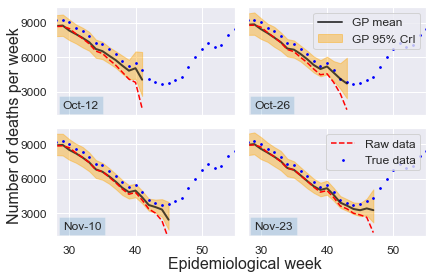

In [295]:
plot_all(crI=95, mean = True, models = [4],showdates=4)
plt.show()
# plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/brazil_backtest_2D_4dates_with_legend_mixture.pdf', bbox_inches='tight')

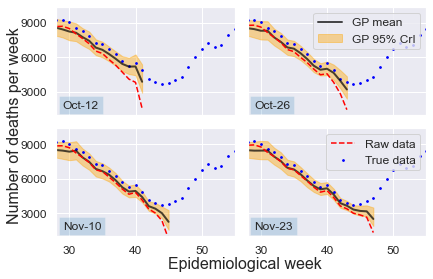

In [296]:
plot_all(crI=95, mean = True, models = [-1],showdates=4)
plt.show()
# plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/brazil_backtest_2D_4dates_with_legend_additive.pdf', bbox_inches='tight')

#### Figures S18-S26

In [269]:
def plot_and_save_for_supplement():
    models_results = [results_SE_4comp, results_SE_2comp, results_nobbs, results_SE_1comp, results_kron,
                  results_matern2comp32, results_matern4comp32, results_matern2comp12,
                  results_matern4comp12, results_kron_additive]
    models_names = ['1D SE+SE data-split GP model', '1D SE+SE GP model', 'NobBS Model', '1D SE GP model', 
                   '2D mixture GP model', '1D SE+Mat(3/2) GP model', '1D SE+Mat(3/2) data-split GP model', 
                   '1D SE+Mat(1/2) GP model',
                  '1D SE+Mat(1/2) data-split GP model', '2D additive GP model']
    for i in range(len(models_names)):
        model_name_no_blanks = models_names[i].replace(' ', '_')
        model_name_no_blanks = model_name_no_blanks.replace('(', '_')
        model_name_no_blanks = model_name_no_blanks.replace(')', '_')
        model_name_no_blanks = model_name_no_blanks.replace('/', '')
        model_name_no_blanks = model_name_no_blanks.replace('__', '_')
        savefile = '../nowcasting/figures/brazil_backtest_' + model_name_no_blanks + '.pdf'
        
        plot_all(crI=95, mean = True, models = [i], showdates=9, title=models_names[i])
        
        plt.savefig(savefile, bbox_inches='tight')
#         plt.show()

C:\Users\iwona\anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The get_realpath_and_stat function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use os.path.realpath and os.stat instead.
C:\Users\iwona\anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The get_realpath_and_stat function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use os.path.realpath and os.stat instead.
C:\Users\iwona\anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The get_realpath_and_stat function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use os.path.realpath and os.stat instead.
C:\Users\iwona\anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The get_realpath_and_stat function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use os.path.realpa

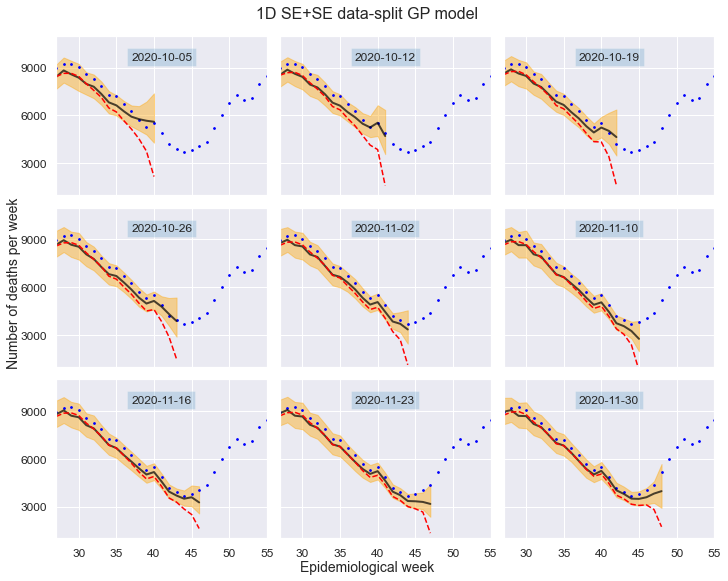

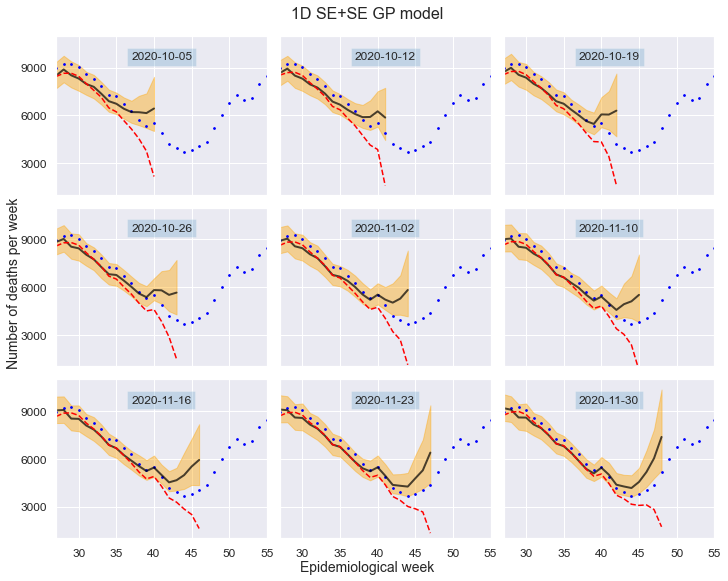

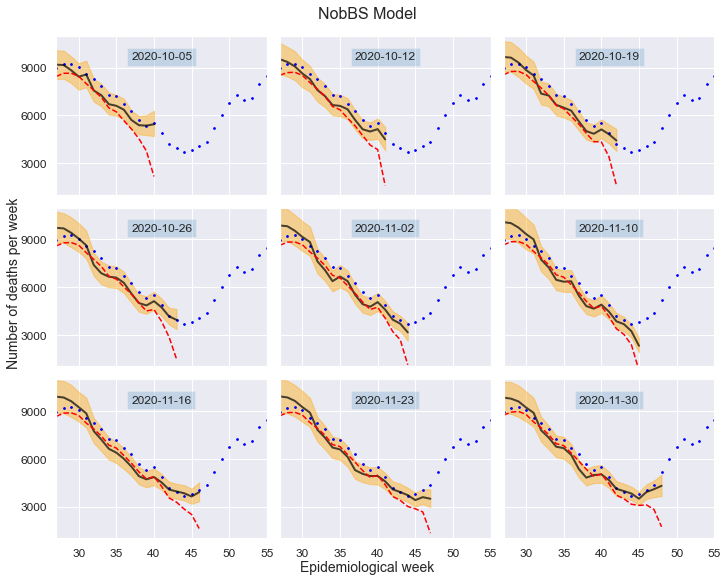

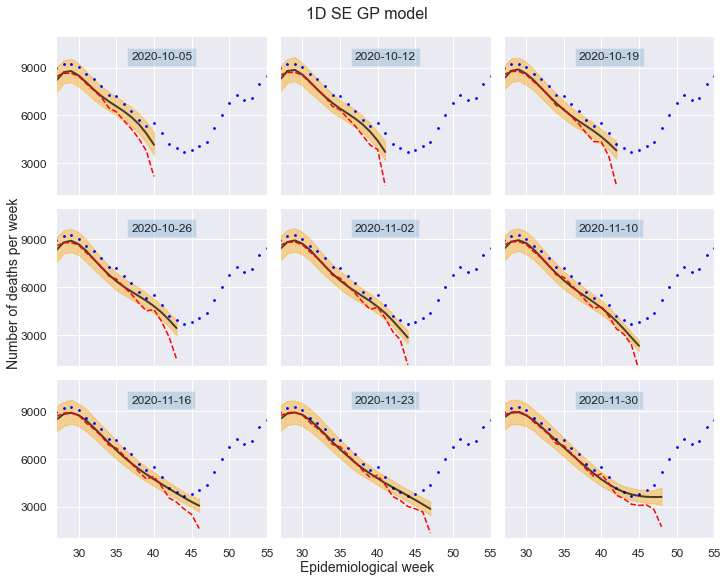

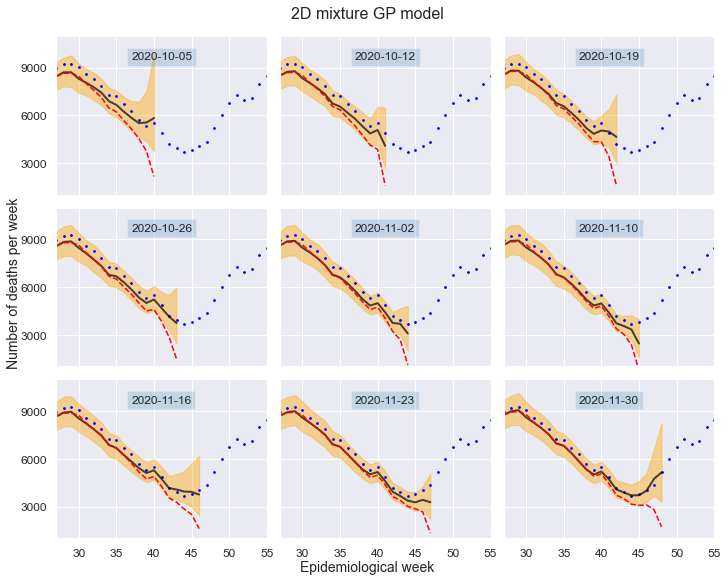

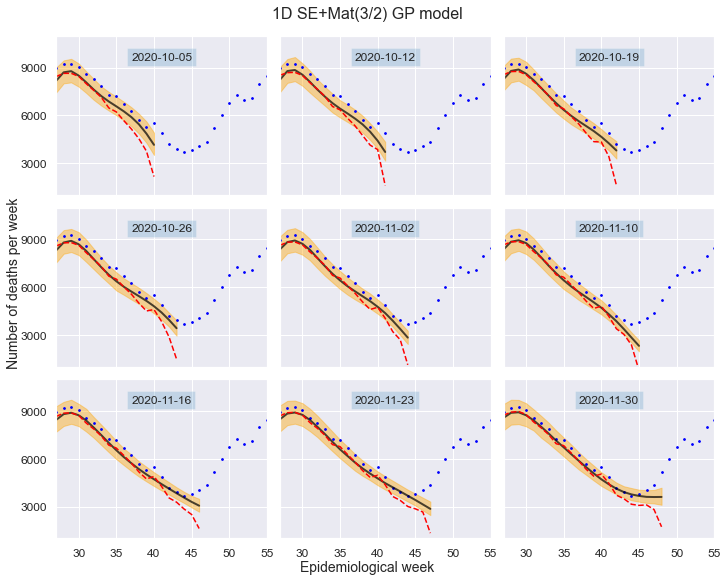

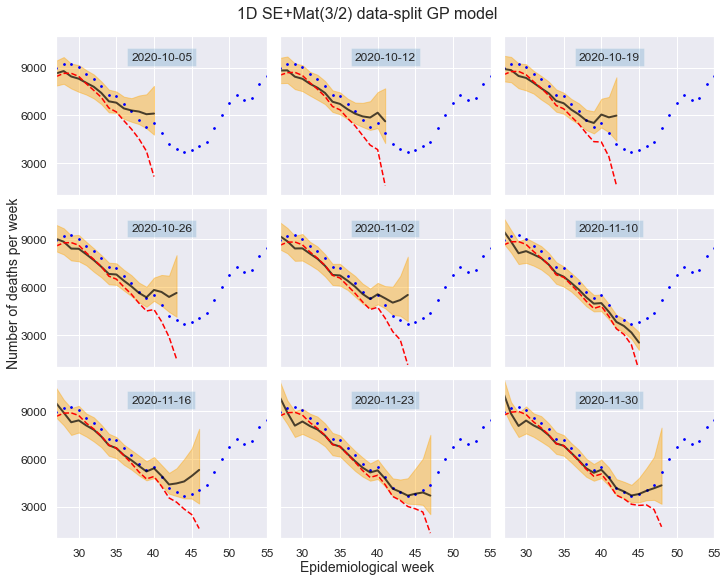

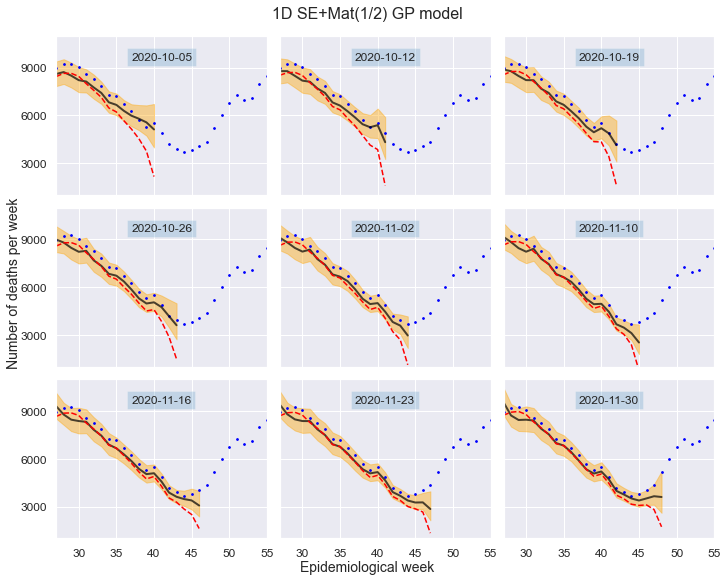

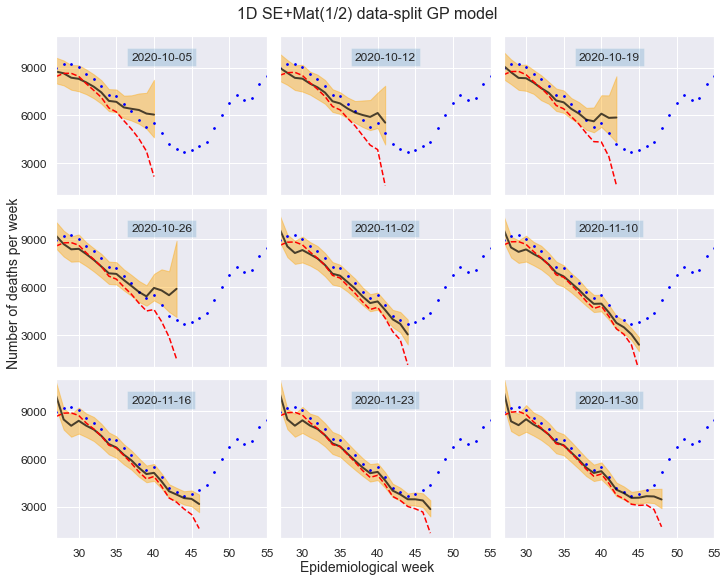

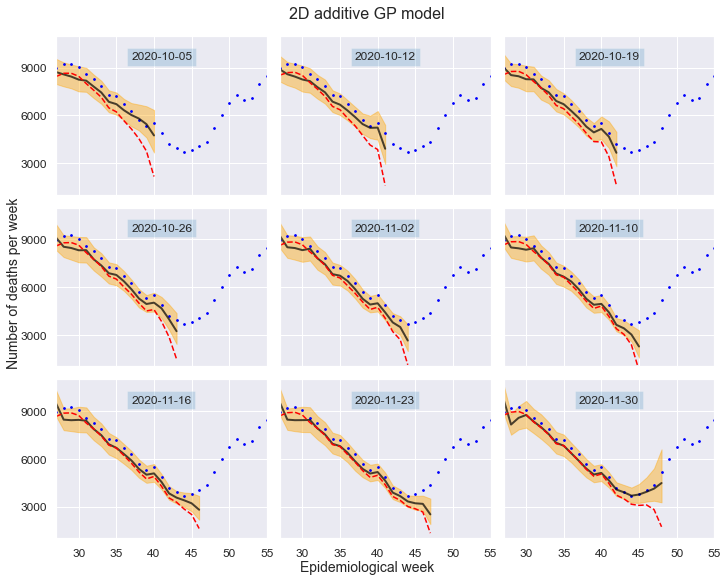

In [270]:
plot_and_save_for_supplement()

### Figure S17 -- delays
#### not enough space in the zip file for the model fits, but if retrospective_tests_run.ipynb is run, then the code below can be used to create Fig S17

In [26]:
# ground_truth, _   = nowcasting_prep('2021-02-09')
ground_truth, _   = nowcasting_prep('2021-06-01')
ground_truth = ground_truth.iloc[:,:-1]

In [27]:
# unpickle fits for 4xSE model fits
def unpickle_fit(model):
    fit_dict = {}
    for d in dates_to_test[0:-3]:
#         with open("tests_results/4xSE_fits/" + model + d + ".pkl", "rb") as f:
        with open("../nowcasting/paper_models/backtesting/stan_models_fits/" + model + '_' + d + ".pkl", "rb") as f:
            data_dict = pickle.load(f)
            # or with a list
            # data_list = pickle.load(f)
        fit_dict.update({d: data_dict['fit']})
    return fit_dict

# fits_SE_4comp = unpickle_fit('SE_4comp_')
fits_SE_4comp = unpickle_fit('kron_2D_additive')
# fits_SE_4comp = unpickle_fit('kron')

In [28]:
n_predict = {}
n_predict_q025 = {}
n_predict_q975 = {}
n_predict_q25 = {}
n_predict_q75 = {}
for k in dates_to_test[:-3]:
    fit_n_predict = fits_SE_4comp[k].extract()['n_predict']
    n_predict.update({k: fit_n_predict.mean(axis = 0)})
    n_predict_q025.update({k: np.quantile(fit_n_predict,0.025,axis=0)})
    n_predict_q975.update({k: np.quantile(fit_n_predict,0.975,axis=0)})
    n_predict_q25.update({k: np.quantile(fit_n_predict,0.25,axis=0)})
    n_predict_q75.update({k: np.quantile(fit_n_predict,0.75,axis=0)})

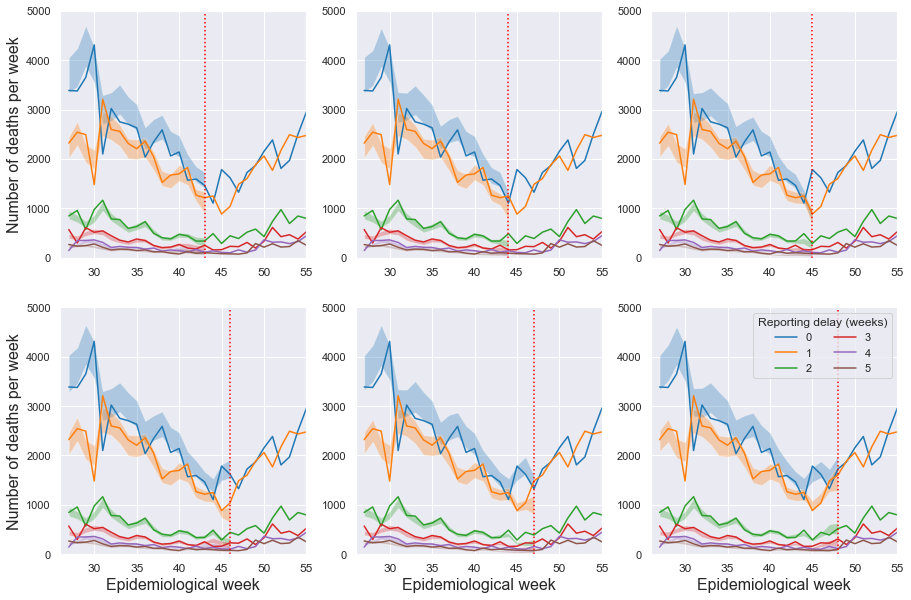

In [30]:
plt.figure(figsize=(15,10))
i = 1
# for k in dates_to_test[0::2]:
for k in dates_to_test[3:-3]:
    sns.set_palette(sns.color_palette("tab10"))
    x_true = ground_truth.index + 27
    x_nowcast =  np.array(range(n_predict_q25[k].shape[0])) + 27

    plt.subplot(2,3,i)
    plt.plot(x_true, ground_truth.iloc[:,0].values, ls = '-', alpha = 1,
             label = str(0))
    plt.fill_between(x_nowcast, n_predict_q25[k][:,0],n_predict_q75[k][:,0], alpha = 0.3)

    for c in range(1,6):
        plt.plot(x_true[0:-c], ground_truth.iloc[:,c].values[0:-c], ls = '-', label = str(c))
        plt.fill_between(x_nowcast, n_predict_q25[k][:,c],n_predict_q75[k][:,c], alpha = 0.3)
        
    # add a vertical line
    plt.axvline(x_nowcast[-1], ls=':', color = 'red')
    plt.xlim([26, 55])
    plt.ylim([0, 5000])

    
    plt.xticks(fontsize=12)
    plt.xticks(fontsize=12)

    if i in [4,5,6]:
        plt.xlabel('Epidemiological week', fontsize=16)
    if i in [1,4]:
        plt.ylabel('Number of deaths per week', fontsize=16)
    if i == 6:
        plt.legend(ncol=2,  title = 'Reporting delay (weeks)')
    
    i = i+1

# plt.savefig('../nowcasting/figures/brazil_backtest_delays_2Dmixture.pdf', bbox_inches='tight')
# plt.savefig('../nowcasting/figures/brazil_backtest_delays_2Dadditive.pdf', bbox_inches='tight')

# plt.show()

## CRPS -- Continuous Ranked Probability Score
For the definition please see

i) https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf

ii) https://www.lokad.com/continuous-ranked-probability-score

iii) https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-020-19652-6/MediaObjects/41467_2020_19652_MOESM1_ESM.pdf page 17

iv) https://pypi.org/project/properscoring/

In [33]:
from properscoring import crps_ensemble as crps

In [34]:
def get_crps_vector(truth_v, samples_m):
    crps_v = []
    for i in range(samples_m.shape[1]):
        samples = samples_m[:, i]
        truth = truth_v[i]
        crps_v.append(crps(truth, samples))
    return np.mean(np.asarray(crps_v))

In [35]:
ensemble = np.random.RandomState(0).randn(1000)
crps(0, ensemble)

0.22971093707298423

In [36]:
# models = ['SE_1comp', 'SE_2comp', 'SE_4comp', 'kron', 'kron_2D_additive', 'nobbs']
models = ['SE_1comp', 'SE_2comp', 'SE_4comp', 'kron_2D_additive', 'nobbs']

crps_models = {}

for m in models:
    print(m)
    fits = unpickle_fit(m)
    all_dates = []
    for d in dates_to_test[:-3]:
        samples = fits[d].extract()['sum_n_predict']
        truth = delays_data_weekly_validation.all_deaths[0:samples.shape[1]].values
        samples = samples[:,-10:]
        truth = truth[-10:]
        all_dates.append(get_crps_vector(truth, samples))
    crps_models.update({m: all_dates})


SE_1comp
SE_2comp
SE_4comp
kron_2D_additive
nobbs


In [37]:
crps_df = pd.DataFrame.from_dict(crps_models)
crps_df.index = RMSE_df.index[0:len(crps_df.index)]
crps_df

,SE_1comp,SE_2comp,SE_4comp,kron_2D_additive,nobbs
2020-10-05,424.567480,326.760383,276.400098,227.930102,289.281661
2020-10-12,511.512548,315.913022,258.696180,250.358460,357.073820
2020-10-19,452.435415,423.337566,267.769353,216.443675,350.227173
2020-10-26,364.700661,415.482484,219.520688,166.969096,299.822376
2020-11-02,414.970841,433.438410,262.888080,208.384011,327.598569
2020-11-10,529.290780,401.833268,345.365820,307.045717,490.241281
2020-11-16,323.880437,501.547833,213.879606,165.536714,279.431891
2020-11-23,378.557237,403.836288,299.460977,244.873982,278.967940
2020-11-30,373.709811,497.685671,250.723869,134.003117,194.808463


In [38]:
def plot_error_per_date_crps(df, title, ls='-', show_mean = True, show_legend=True):
    x = df.columns
    color_dict = {'nobbs': 'tab:blue', 'SE_4comp': 'tab:green', 'kron': 'tab:orange',
                  'NobBS': 'tab:blue', 'matern_4comp12': 'tab:green',
                 'kron_2D_additive': 'tab:red'}
    label_dict = {'nobbs': 'NobBS', 'SE_4comp': '1D split SE+SE', 'kron': '2D mixture',
                  'NobBS': 'NobBS', 'matern_4comp12': '2x(SE+Mat(1/2) GP model',
                 'kron_2D_additive': '2D additive'}

    for r in range(len(df.index)):

#         if df.index[r] in ['NobBS', 'nobbs', 'kron', 'SE_4comp', 'kron_2D_additive']:
        if df.index[r] in ['NobBS', 'nobbs', 'SE_4comp', 'kron_2D_additive']:

            plt.plot(x, df.iloc[r,:].values, label=label_dict[df.index[r]],
                     color= color_dict[df.index[r]], ls=ls)
            if show_mean:
                plt.axhline(df.iloc[r,:].mean(), ls='--', color= color_dict[df.index[r]])

    xticks = list(x[::2]) # take every other date
    xlabs = [datetime.datetime.strptime(d,'%Y-%m-%d').strftime("%b-%d") for d in xticks]
    plt.xticks(xticks, labels=xlabs, rotation=45,fontsize=12)
    plt.yticks(range(100,510,100), fontsize=12)
#     plt.ylim([200, 900])
    plt.ylabel(title,fontsize=16)
    if show_legend:
        plt.legend(fontsize='medium')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

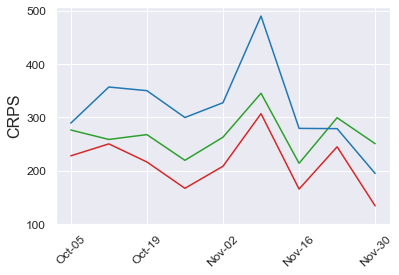

In [39]:
plot_error_per_date_crps(crps_df.iloc[:,:].T, 'CRPS', show_mean=False, show_legend=False)
# plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/crps_lines.pdf', bbox_inches='tight')

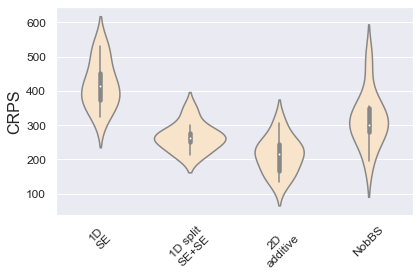

In [41]:
df_for_boxplot_crps = crps_df.iloc[:,:].copy()

df_for_boxplot_crps.rename(columns={"SE_4comp": "1D split\nSE+SE",
                                    "SE_2comp": " 1D\nSE+SE",
                               "nobbs": "NobBS", "SE_1comp": "1D\nSE", 
                              "kron": '2D\nmixture',
                              "kron_2D_additive": '2D\nadditive'},
                                inplace=True)



# order = ['1D\nSE', '1D split\nSE+SE',  '2D\nmixture', '2D\nadditive', 'NobBS']
order = ['1D\nSE', '1D split\nSE+SE', '2D\nadditive', 'NobBS']


df_for_boxplot_crps.drop(columns=[col for col in df_for_boxplot_crps if col not in order], inplace=True)

melt = pd.melt(df_for_boxplot_crps)

melt.variable = pd.Categorical(melt.variable, categories=order)
melt.sort_values(by='variable', inplace=True)


sns.violinplot(x="variable", y="value", data=melt, color='bisque',
            showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"red",
                      "markersize":"5"},
            orient="v", alpha=0.3)
plt.xticks(fontsize=12, rotation = 45)
plt.yticks(fontsize=12)

plt.xlabel('')
plt.ylabel('CRPS', fontsize=16)
plt.tight_layout()
# plt.show()

# plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/crps_violin.pdf', bbox_inches='tight')

## Daily deaths interpolation

In [12]:
results_SE_4comp.keys()

dict_keys(['2020-09-07', '2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05', '2020-10-12', '2020-10-19', '2020-10-26', '2020-11-02', '2020-11-10', '2020-11-16', '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14', '2020-12-21'])

In [13]:
date_Rt = '2020-11-23'

In [26]:
def interpolate_days(nowcasted_data, validation_data_daily, metric_midweek, date_Rt, plot = True):
    """Takes in the weekly nowcasts of the data (nowcast_data) 
    and using the metric_midweek (mean, q25, q025, q75 or q975) gets interpolation of daily deaths
    up to date_Rt, which can be then used for the Rt model"""
    
    nowcasted_data['mean_daily'] = nowcasted_data[metric_midweek] / 7

    daily_data = validation_data_daily[validation_data_daily.index <= date_Rt]
    nowcasted_data_daily = pd.DataFrame(columns = ['Date', 'Week', 'Deaths'])
    nowcasted_data_daily['Date'] = daily_data.index
    nowcasted_data_daily['Week'] = daily_data['week'].values.astype(int)
    
    # in the nowcasted_data_daily set the mean daily deaths to happen on day 4 of each week
    number_of_weeks = nowcasted_data_daily['Week'].values[-1]
    for week in range(number_of_weeks+1):
#         print(week)
        day_deaths = nowcasted_data[nowcasted_data['week'] == week]['mean_daily'].values[0] 
        middle_day = nowcasted_data_daily[nowcasted_data_daily['Week'] == week]['Date'].values[3] # this is the 4th day
        nowcasted_data_daily.loc[nowcasted_data_daily['Date'] == middle_day, 'Deaths'] = day_deaths
    # now interpolate the rest
    x = np.array(nowcasted_data_daily.index.values, dtype=np.float64)
    y = np.array(nowcasted_data_daily['Deaths'].values, dtype=np.float64)

    x_known = x[np.argwhere(~np.isnan(y))].flatten()
    y_known = y[np.argwhere(~np.isnan(y))].flatten()

    spline = scipy.interpolate.splrep(x_known, y_known, k=1)
    # fill in the interpolated data
    nowcasted_data_daily_interpolated = nowcasted_data_daily.copy()
    values_interpolated = scipy.interpolate.splev(x, spline).astype(int)
    nowcasted_data_daily_interpolated['Deaths'] = values_interpolated
    
    if plot:
        plt.figure(figsize=[7,5])
        plt.plot(x_known, y_known, 'o',
                 x, validation_data_daily['all_deaths'].values[0:len(x)], '*',
                 x, values_interpolated, ':')
        plt.legend(['nowcasted mean', 'true', 'spline'], loc = 'best')

        plt.xlabel('Date index')
        plt.ylabel('Deaths')
        plt.title('Nowcasting per day using ' + metric_midweek)
        plt.show()
        
    return nowcasted_data_daily_interpolated


In [27]:
date_Rt = '2020-10-12'
# interpolate to get daily deaths rather than per week
nowcasted_data = results_SE_4comp[date_Rt].copy()
validation_data_daily = data_validation_daily.copy()


mean_interp = interpolate_days(nowcasted_data, validation_data_daily, 'mean', date_Rt, plot = False)
q025_interp = interpolate_days(nowcasted_data, validation_data_daily, 'q025', date_Rt, plot = False)
q975_interp = interpolate_days(nowcasted_data, validation_data_daily, 'q975', date_Rt, plot = False)
q25_interp = interpolate_days(nowcasted_data, validation_data_daily, 'q25', date_Rt, plot = False)
q75_interp = interpolate_days(nowcasted_data, validation_data_daily, 'q75', date_Rt, plot = False)

print('Mean', mean_interp['Deaths'].values[281-181])
print('50% CrI:', q25_interp['Deaths'].values[281-181], '-', q75_interp['Deaths'].values[281-181])
print('95% CrI:', q025_interp['Deaths'].values[281-181], '-', q975_interp['Deaths'].values[281-181])
print('Width of the 95% CrI:',  q975_interp['Deaths'].values[281-181] - q025_interp['Deaths'].values[281-181])


Mean 687
50% CrI: 618 - 743
95% CrI: 530 - 910
Width of the 95% CrI: 380


### Figure S2 -- example of interpolation to get daily nowcasts

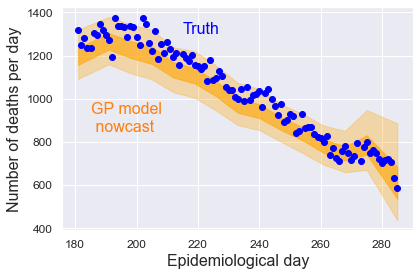

In [29]:
daily_data = validation_data_daily[validation_data_daily.index <= date_Rt]
x = np.array(range(len(daily_data.index.values))) + 181

# plt.plot(x, daily_data['all_deaths'].values[0:len(x)], 'o',
#          x, mean_interp['Deaths'].values, 'r-')
# plt.legend(['True', 'Nowcasted'], loc = 'best', fontsize=12)
# plt.fill_between(x, y1=q025_interp['Deaths'].values,
#                  y2=q975_interp['Deaths'].values, alpha = 0.3)
# plt.fill_between(x, y1=q25_interp['Deaths'].values,
#                  y2=q75_interp['Deaths'].values, alpha = 0.5)

plt.plot(x, daily_data['all_deaths'].values[0:len(x)], 'o',color = 'blue', label = 'Truth')
         
plt.fill_between(x, y1=q025_interp['Deaths'].values,
                 y2=q975_interp['Deaths'].values, color='orange', alpha = 0.3)
plt.fill_between(x, y1=q25_interp['Deaths'].values,
                 y2=q75_interp['Deaths'].values, color='orange', alpha = 0.6, label = 'GP nowcast')
# plt.legend(fontsize=12)

plt.text(max(x)-70, 1300, 'Truth', color = 'blue', size=16)
plt.text(max(x)-100, 850, 'GP model\n nowcast', color = 'tab:orange', size=16)

plt.xlabel('Epidemiological day', fontsize=16)
plt.ylabel('Number of deaths per day', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()
